v_1: AutoETS, ETS 비교

# Load data

In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
all = pd.concat([train, test], axis = 0)
transactions = pd.read_csv("data/transactions.csv")
holiday_events = pd.read_csv("data/holidays_events.csv")
stores = pd.read_csv("data/stores.csv")
oil = pd.read_csv("data/oil.csv")

# feature engineering

In [2]:
# https://www.kaggle.com/code/ekrembayar/holiday_events-events-data-manipulation-time-features/notebook
# Deal multiple holiday
# 확인 후 리팩토링 필요

tr1 = holiday_events[(holiday_events.type == "Holiday") & (holiday_events.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holiday_events[(holiday_events.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]

holiday_events = holiday_events[(holiday_events.transferred == False) & (holiday_events.type != "Transfer")].drop("transferred", axis = 1)
holiday_events = holiday_events.append(tr).reset_index(drop = True)


# Additional Holidays
# ------------------------------------------------------
holiday_events["description"] = holiday_events["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holiday_events["type"] = np.where(holiday_events["type"] == "Additional", "Holiday", holiday_events["type"])

# Bridge Holidays
# ------------------------------------------------------
holiday_events["description"] = holiday_events["description"].str.replace("Puente ", "")
holiday_events["type"] = np.where(holiday_events["type"] == "Bridge", "Holiday", holiday_events["type"])

 
# Work Day Holidays, that is meant to payback the Bridge.
# ------------------------------------------------------
work_day = holiday_events[holiday_events.type == "Work Day"]  
holiday_events = holiday_events[holiday_events.type != "Work Day"]  


# Split
# ------------------------------------------------------

# Events are national
events = holiday_events[holiday_events.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)

holiday_events = holiday_events[holiday_events.type != "Event"].drop("type", axis = 1)
regional = holiday_events[holiday_events.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
national = holiday_events[holiday_events.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
local = holiday_events[holiday_events.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()

# EVENTS
events["events"] =np.where(events.events.str.contains("futbol"), "Futbol", events.events)

# Merge
holiday_events = pd.concat([events, regional, national, local], axis = 0).reset_index(drop = True)

# convert datetime to str
# some additional date features
date_info = pd.DataFrame({"date": pd.date_range(start=all["date"].min(), end=all["date"].max())})

date_info["year"] = date_info["date"].dt.year
date_info["month"] = date_info["date"].dt.month
date_info["day"] = date_info["date"].dt.day
date_info["dayofweek"] = date_info["date"].dt.dayofweek
date_info["weekend"] = (date_info["dayofweek"] >= 5).astype(int)
date_info["week"] = date_info["date"].dt.week
date_info["quarter"] = date_info["date"].dt.quarter
date_info["season"] = date_info["month"] % 12 // 3 + 1

date_info["date"] = date_info["date"].astype(str)

/tmp/ipykernel_3734604/3777914067.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  holiday_events = holiday_events.append(tr).reset_index(drop = True)
/tmp/ipykernel_3734604/3777914067.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  holiday_events["description"] = holiday_events["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
/tmp/ipykernel_3734604/3777914067.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  holiday_events["description"] = holiday_events["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
/tmp/ipykernel_3734604/3777914067.py:57: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Pl

# make train

In [3]:
# make train
merged = pd.merge(all, transactions, on=["date", "store_nbr"], how="left")
merged = pd.merge(merged, stores, on=["store_nbr"], how="left")
merged = pd.merge(merged, holiday_events, on=["date", "city", "state"], how="left")
merged = pd.merge(merged, date_info, on=["date"], how="left")
merged = pd.merge(merged, oil, on=["date"], how="left")

# 없는 값은 거래가 발생하지 않은 것으로 가정
merged["transactions"] = merged["transactions"].fillna(0)

In [4]:
# fill na
# TODO: Normal은 0으로 취급될 수 있게 변경 필요
merged["events"] = merged["events"].fillna("Normal")
merged["holiday_regional"] = merged["holiday_regional"].fillna("Normal")
merged["holiday_national"] = merged["holiday_national"].fillna("Normal")
merged["holiday_local"] = merged["holiday_local"].fillna("Normal")

In [5]:
# FIXME: for simplicity
# use only family=AUTOMOTIVE, store_nbr=1
# idx = (merged["family"] == "AUTOMOTIVE") & (merged["store_nbr"] == 1)
# merged = merged[idx]

In [6]:
# make item_id
merged["item_id"] = merged["family"] + "_" + merged["store_nbr"].astype(str)

# separate static and covariates
drop_cols = []
static_cols = ["store_nbr","family","type","cluster", "state", "city"]

static_features = merged[static_cols + ["item_id"]].drop_duplicates()
static_features.set_index("item_id", inplace=True)
merged = merged.drop(columns=drop_cols + static_cols)

merged["date"] = pd.to_datetime(merged["date"], format="%Y-%m-%d")
merged.sort_values(by=["item_id","date"], inplace=True)

In [7]:
# fill na
# TODO: Normal은 0으로 취급될 수 있게 변경 필요
merged["events"] = merged["events"].fillna("Normal")
merged["holiday_regional"] = merged["holiday_regional"].fillna("Normal")
merged["holiday_national"] = merged["holiday_national"].fillna("Normal")
merged["holiday_local"] = merged["holiday_local"].fillna("Normal")
merged["dcoilwtico"] = merged["dcoilwtico"].fillna(method="ffill")
merged["dcoilwtico"] = merged["dcoilwtico"].fillna(method="bfill")

In [8]:
# one hot encoding
categorical_col = ["events", "holiday_regional", "holiday_national", "holiday_local"]
encoded = pd.get_dummies(merged[categorical_col + ["item_id", "date"]], columns=categorical_col)
merged = pd.merge(merged, encoded, on=["item_id", "date"], how="left")
merged.drop(columns=categorical_col, inplace=True)

In [9]:
merged.head()

,id,date,sales,onpromotion,transactions,year,month,day,dayofweek,weekend,week,quarter,season,dcoilwtico,item_id,events_Normal,holiday_regional_Normal,holiday_national_Normal,holiday_local_Normal
0,0,2013-01-01,0.0,0,0.0,2013,1,1,1,0,1,1,1,93.14,AUTOMOTIVE_1,1,1,1,1
1,1782,2013-01-02,2.0,0,2111.0,2013,1,2,2,0,1,1,1,93.14,AUTOMOTIVE_1,1,1,1,1
2,3564,2013-01-03,3.0,0,1833.0,2013,1,3,3,0,1,1,1,92.97,AUTOMOTIVE_1,1,1,1,1
3,5346,2013-01-04,3.0,0,1863.0,2013,1,4,4,0,1,1,1,93.12,AUTOMOTIVE_1,1,1,1,1
4,7128,2013-01-05,5.0,0,1509.0,2013,1,5,5,1,1,1,1,93.12,AUTOMOTIVE_1,1,1,1,1


# Make TimeSeriesDataFrame

In [10]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

timeseries_df = TimeSeriesDataFrame.from_data_frame(
    merged,
    id_column="item_id",
    timestamp_column="date"
)
timeseries_df = timeseries_df.to_regular_index(freq="D")

categorical_col = ["store_nbr", "family", "type", "cluster", "city", "state"]
for col in categorical_col:
    # encoding to number
    static_features[col] = static_features[col].astype("category")

/home/mysunk/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
train_data, test_data = timeseries_df.split_by_time(pd.Timestamp("2017-08-16"))

train_data.static_features = static_features
test_data.static_features = static_features

train_data["sales"] = np.log1p(train_data["sales"])

# christmas 등
train_data = train_data.fill_missing_values('pad', value = 0)

In [12]:
known_covariates_cols = list(train_data.columns)
known_covariates_cols.remove("sales")
known_covariates_cols.remove("id")
known_covariates_cols

['onpromotion',
 'transactions',
 'year',
 'month',
 'day',
 'dayofweek',
 'weekend',
 'week',
 'quarter',
 'season',
 'dcoilwtico',
 'events_Normal',
 'holiday_regional_Normal',
 'holiday_national_Normal',
 'holiday_local_Normal']

# Train-val split

## 1. Splitter로 data split
* https://github.com/autogluon/autogluon/blob/master/timeseries/src/autogluon/timeseries/splitter.py
* sliding window size는 prediction_length로 고정
* num_windows = validation set 수
  * num_windows 개의 validation set 수가 나오기 위해 기간을 조절함
* val_data_split의 index는 None:(train_data에서의 index), timestamp
* 일반적인 cross validation 형식과는 다르게 fitting은 그냥 앞의 데이터로 하고 validation만 sliding하는 식으로 하는듯

In [13]:
from autogluon.timeseries.splitter import MultiWindowSplitter

splitter = MultiWindowSplitter(num_windows=3)
train_data_split, val_data_split = splitter.split(train_data, prediction_length = 16)

In [14]:
train_data_split.shape, val_data_split.shape

((2922480, 17), (8938512, 17))

In [15]:
val_data_split.index

MultiIndex([('AUTOMOTIVE_1_[None:None]', '2013-01-01'),
            ('AUTOMOTIVE_1_[None:None]', '2013-01-02'),
            ('AUTOMOTIVE_1_[None:None]', '2013-01-03'),
            ('AUTOMOTIVE_1_[None:None]', '2013-01-04'),
            ('AUTOMOTIVE_1_[None:None]', '2013-01-05'),
            ('AUTOMOTIVE_1_[None:None]', '2013-01-06'),
            ('AUTOMOTIVE_1_[None:None]', '2013-01-07'),
            ('AUTOMOTIVE_1_[None:None]', '2013-01-08'),
            ('AUTOMOTIVE_1_[None:None]', '2013-01-09'),
            ('AUTOMOTIVE_1_[None:None]', '2013-01-10'),
            ...
            (    'SEAFOOD_9_[None:-32]', '2017-07-05'),
            (    'SEAFOOD_9_[None:-32]', '2017-07-06'),
            (    'SEAFOOD_9_[None:-32]', '2017-07-07'),
            (    'SEAFOOD_9_[None:-32]', '2017-07-08'),
            (    'SEAFOOD_9_[None:-32]', '2017-07-09'),
            (    'SEAFOOD_9_[None:-32]', '2017-07-10'),
            (    'SEAFOOD_9_[None:-32]', '2017-07-11'),
            (    'SEAFOOD_9_[Non

In [16]:
train_data_split

id     sales  onpromotion  transactions  \
item_id      timestamp                                                    
AUTOMOTIVE_1 2013-01-01        0.0  0.000000          0.0           0.0   
             2013-01-02     1782.0  1.098612          0.0        2111.0   
             2013-01-03     3564.0  1.386294          0.0        1833.0   
             2013-01-04     5346.0  1.386294          0.0        1863.0   
             2013-01-05     7128.0  1.791759          0.0        1509.0   
...                            ...       ...          ...           ...   
SEAFOOD_9    2017-06-24  2908223.0  3.295837          3.0        2116.0   
             2017-06-25  2910005.0  3.226685          0.0        2054.0   
             2017-06-26  2911787.0  2.573528          0.0        1800.0   
             2017-06-27  2913569.0  2.456336          0.0        1730.0   
             2017-06-28  2915351.0  2.555598          0.0        1634.0   

                           year  month   day  dayofweek  weekend  week  \
item_id      timestamp                                                   
AUTOMOTIVE_1 2013-01-01  2013.0    1.0   1.0        1.0      0.0   1.0   
             2013-01-02  2013.0    1.0   2.0        2.0      0.0   1.0   
             2013-01-03  2013.0    1.0   3.0        3.0      0.0   1.0   
             2013-01-04  2013.0    1.0   4.0        4.0      0.0   1.0   
             2013-01-05  2013.0    1.0   5.0        5.0      1.0   1.0   
...                         ...    ...   ...        ...      ...   ...   
SEAFOOD_9    2017-06-24  2017.0    6.0  24.0        5.0      1.0  25.0   
             2017-06-25  2017.0    6.0  25.0        6.0      1.0  25.0   
             2017-06-26  2017.0    6.0  26.0        0.0      0.0  26.0   
             2017-06-27  2017.0    6.0  27.0        1.0      0.0  26.0   
             2017-06-28  2017.0    6.0  28.0        2.0      0.0  26.0   

                         quarter  season  dcoilwtico  events_Normal  \
item_id      timestamp                                                
AUTOMOTIVE_1 2013-01-01      1.0     1.0       93.14            1.0   
             2013-01-02      1.0     1.0       93.14            1.0   
             2013-01-03      1.0     1.0       92.97            1.0   
             2013-01-04      1.0     1.0       93.12            1.0   
             2013-01-05      1.0     1.0       93.12            1.0   
...                          ...     ...         ...            ...   
SEAFOOD_9    2017-06-24      2.0     3.0       42.86            1.0   
             2017-06-25      2.0     3.0       42.86            1.0   
             2017-06-26      2.0     3.0       43.24            1.0   
             2017-06-27      2.0     3.0       44.25            1.0   
             2017-06-28      2.0     3.0       44.74            1.0   

                         holiday_regional_Normal  holiday_national_Normal  \
item_id      timestamp                                                      
AUTOMOTIVE_1 2013-01-01                      1.0                      1.0   
             2013-01-02                      1.0                      1.0   
             2013-01-03                      1.0                      1.0   
             2013-01-04                      1.0                      1.0   
             2013-01-05                      1.0                      1.0   
...                                          ...                      ...   
SEAFOOD_9    2017-06-24                      1.0                      1.0   
             2017-06-25                      1.0                      1.0   
             2017-06-26                      1.0                      1.0   
             2017-06-27                      1.0                      1.0   
             2017-06-28                      1.0                      1.0   

                         holiday_local_Normal  
item_id      timestamp                         
AUTOMOTIVE_1 2013-01-01                   1.0  
             2013-01-02

In [17]:
val_data_split.loc["AUTOMOTIVE_1_[None:None]"]

,id,sales,onpromotion,transactions,year,month,day,dayofweek,weekend,week,quarter,season,dcoilwtico,events_Normal,holiday_regional_Normal,holiday_national_Normal,holiday_local_Normal
timestamp,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.000000,0.0,0.0,2013.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,93.14,1.0,1.0,1.0,1.0
2013-01-02,1782.0,1.098612,0.0,2111.0,2013.0,1.0,2.0,2.0,0.0,1.0,1.0,1.0,93.14,1.0,1.0,1.0,1.0
2013-01-03,3564.0,1.386294,0.0,1833.0,2013.0,1.0,3.0,3.0,0.0,1.0,1.0,1.0,92.97,1.0,1.0,1.0,1.0
2013-01-04,5346.0,1.386294,0.0,1863.0,2013.0,1.0,4.0,4.0,0.0,1.0,1.0,1.0,93.12,1.0,1.0,1.0,1.0
2013-01-05,7128.0,1.791759,0.0,1509.0,2013.0,1.0,5.0,5.0,1.0,1.0,1.0,1.0,93.12,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,2991978.0,0.693147,0.0,570.0,2017.0,8.0,11.0,4.0,0.0,32.0,3.0,3.0,48.81,1.0,1.0,1.0,1.0
2017-08-12,2993760.0,1.945910,0.0,1004.0,2017.0,8.0,12.0,5.0,1.0,32.0,3.0,3.0,48.81,1.0,1.0,1.0,1.0
2017-08-13,2995542.0,0.693147,0.0,416.0,2017.0,8.0,13.0,6.0,1.0,32.0,3.0,3.0,48.81,1.0,1.0,1.0,1.0


## 2. fitting시 splitter 지정
* splitter 객체를 전달하거나 몇가지 option 지정

In [18]:
from autogluon.timeseries.splitter import MultiWindowSplitter
splitter = MultiWindowSplitter(num_windows=1)
predictor = TimeSeriesPredictor(known_covariates_names=known_covariates_cols, target="sales", prediction_length=16, validation_splitter=splitter,
                                eval_metric="RMSE")

# Model test
* 기본적으로, Auto가 붙지 않은 모델은 default hyperparameter로 피팅되거나, 지정된 파라미터로 학습됨
* Hyperparameter tuning법
  1. Auto 모델을 사용 
  2. search space를 지정


fit parameters
* hyperparameters: Determines what models are trained and what hyperparameters are used by each model.
* hyperparameter_tune_kwargs: Hyperparameter tuning strategy and kwarg

* ETS
  * https://www.statsmodels.org/stable/generated/statsmodels.tsa.exponential_smoothing.ets.ETSModel.html
  * https://otexts.com/fpp3/expsmooth.html

In [30]:
import autogluon.core as ag
from autogluon.timeseries.splitter import MultiWindowSplitter
splitter = MultiWindowSplitter(num_windows=1)
predictor = TimeSeriesPredictor(known_covariates_names=known_covariates_cols, target="sales", prediction_length=16, validation_splitter=splitter,
                                eval_metric="RMSE")
predictor.fit(train_data=train_data,
              hyperparameters={
            "ETS": {"seasonal_period": ag.space.Int(1, 20),
                "seasonal": ag.space.Categorical("add", "mul", None),
                "damped_trend": ag.space.Categorical(True, False),
                "trend": ag.space.Categorical("add", "mul", None),
                "error": ag.space.Categorical("add", "mul")}
            },hyperparameter_tune_kwargs={
                "scheduler": "local",
                "searcher": "auto",
                "num_trials": 30,
            }, enable_ensemble=False)

No path specified. Models will be saved in: "AutogluonModels/ag-20230606_065447/"
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': False,
 'evaluation_metric': 'RMSE',
 'hyperparameter_tune_kwargs': {'num_trials': 30,
                                'scheduler': 'local',
                                'searcher': 'auto'},
 'hyperparameters': {'ETS': {'damped_trend': Categorical[True, False],
                             'error': Categorical['add', 'mul'],
                             'seasonal': Categorical['add', 'mul', None],
                             'seasonal_period': Int: lower=1, upper=20,
                             'trend': Categorical['add', 'mul', None]}},
 'prediction_length': 16,
 'random_seed': None,
 'target': 'sales',
 'time_limit': None}
Provided training data set with 3008016 rows, 1782 items (item = single time series). Average time series length is 1688.0.
Training artifacts will b

  0%|          | 0/30 [00:00<?, ?it/s]

ETS/T1 with seasonal = add requires seasonal_period > 1 (received seasonal_period = 1). Disabling seasonality.
ETS/T2 with seasonal = mul requires seasonal_period > 1 (received seasonal_period = 1). Disabling seasonality.
	endog must be strictly positive when using multiplicative error, trend or seasonal components.
	endog must be strictly positive when using multiplicative error, trend or seasonal components.
	Can only dampen the trend component
	endog must be strictly positive when using multiplicative error, trend or seasonal components.
	endog must be strictly positive when using multiplicative error, trend or seasonal components.
	endog must be strictly positive when using multiplicative error, trend or seasonal components.
	endog must be strictly positive when using multiplicative error, trend or seasonal components.
	endog must be strictly positive when using multiplicative error, trend or seasonal components.
ETS/T10 with seasonal = mul requires seasonal_period > 1 (received se

In [17]:
import autogluon.core as ag
from autogluon.timeseries.splitter import MultiWindowSplitter
splitter = MultiWindowSplitter(num_windows=1)
predictor = TimeSeriesPredictor(known_covariates_names=known_covariates_cols, target="sales", prediction_length=16, validation_splitter=splitter,
                                eval_metric="RMSE")
predictor_saved = predictor.load(path = "AutogluonModels/ag-20230606_065447/")

Loading predictor from path AutogluonModels/ag-20230606_065447/


In [24]:
predictor_saved.fit_summary()

****************** Summary of fit() ******************
Estimated performance of each model:
     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  ETS/T19  -0.486472     140.437054           0.000260          3
1   ETS/T1  -0.514689      48.653186           0.001011          1
2  ETS/T21  -0.515977     223.335069           0.000094          4
3  ETS/T12  -0.517936      59.900343           0.000130          2
Number of models trained: 4
Types of models trained:
{'ETSModel'}
****************** End of fit() summary ******************


{'model_types': {'ETS/T1': 'ETSModel',
  'ETS/T12': 'ETSModel',
  'ETS/T19': 'ETSModel',
  'ETS/T21': 'ETSModel'},
 'model_performance': {'ETS/T1': -0.5146888629533589,
  'ETS/T12': -0.5179362576815791,
  'ETS/T19': -0.4864715308474021,
  'ETS/T21': -0.5159774341580372},
 'model_best': 'ETS/T19',
 'model_paths': {'ETS/T1': 'AutogluonModels/ag-20230606_065447/models/ETS/T1/',
  'ETS/T12': 'AutogluonModels/ag-20230606_065447/models/ETS/T12/',
  'ETS/T19': 'AutogluonModels/ag-20230606_065447/models/ETS/T19/',
  'ETS/T21': 'AutogluonModels/ag-20230606_065447/models/ETS/T21/'},
 'model_fit_times': {'ETS/T1': 0.001010894775390625,
  'ETS/T12': 0.00013017654418945312,
  'ETS/T19': 0.0002598762512207031,
  'ETS/T21': 9.393692016601562e-05},
 'model_pred_times': {'ETS/T1': 48.653186082839966,
  'ETS/T12': 59.90034294128418,
  'ETS/T19': 140.43705415725708,
  'ETS/T21': 223.33506894111633},
 'model_hyperparams': {'ETS/T1': {'seasonal_period': 1,
   'seasonal': 'add',
   'damped_trend': True,
   

In [18]:
train_data

id     sales  onpromotion  transactions  \
item_id      timestamp                                                    
AUTOMOTIVE_1 2013-01-01        0.0  0.000000          0.0           0.0   
             2013-01-02     1782.0  1.098612          0.0        2111.0   
             2013-01-03     3564.0  1.386294          0.0        1833.0   
             2013-01-04     5346.0  1.386294          0.0        1863.0   
             2013-01-05     7128.0  1.791759          0.0        1509.0   
...                            ...       ...          ...           ...   
SEAFOOD_9    2017-08-11  2993759.0  3.212093          0.0        1848.0   
             2017-08-12  2995541.0  2.882508          4.0        1920.0   
             2017-08-13  2997323.0  3.044522          0.0        1745.0   
             2017-08-14  2999105.0  2.890372          0.0        1971.0   
             2017-08-15  3000887.0  2.833213          0.0        2155.0   

                           year  month   day  dayofweek  weekend  week  \
item_id      timestamp                                                   
AUTOMOTIVE_1 2013-01-01  2013.0    1.0   1.0        1.0      0.0   1.0   
             2013-01-02  2013.0    1.0   2.0        2.0      0.0   1.0   
             2013-01-03  2013.0    1.0   3.0        3.0      0.0   1.0   
             2013-01-04  2013.0    1.0   4.0        4.0      0.0   1.0   
             2013-01-05  2013.0    1.0   5.0        5.0      1.0   1.0   
...                         ...    ...   ...        ...      ...   ...   
SEAFOOD_9    2017-08-11  2017.0    8.0  11.0        4.0      0.0  32.0   
             2017-08-12  2017.0    8.0  12.0        5.0      1.0  32.0   
             2017-08-13  2017.0    8.0  13.0        6.0      1.0  32.0   
             2017-08-14  2017.0    8.0  14.0        0.0      0.0  33.0   
             2017-08-15  2017.0    8.0  15.0        1.0      0.0  33.0   

                         quarter  season  dcoilwtico  events_Normal  \
item_id      timestamp                                                
AUTOMOTIVE_1 2013-01-01      1.0     1.0       93.14            1.0   
             2013-01-02      1.0     1.0       93.14            1.0   
             2013-01-03      1.0     1.0       92.97            1.0   
             2013-01-04      1.0     1.0       93.12            1.0   
             2013-01-05      1.0     1.0       93.12            1.0   
...                          ...     ...         ...            ...   
SEAFOOD_9    2017-08-11      3.0     3.0       48.81            1.0   
             2017-08-12      3.0     3.0       48.81            1.0   
             2017-08-13      3.0     3.0       48.81            1.0   
             2017-08-14      3.0     3.0       47.59            1.0   
             2017-08-15      3.0     3.0       47.57            1.0   

                         holiday_regional_Normal  holiday_national_Normal  \
item_id      timestamp                                                      
AUTOMOTIVE_1 2013-01-01                      1.0                      1.0   
             2013-01-02                      1.0                      1.0   
             2013-01-03                      1.0                      1.0   
             2013-01-04                      1.0                      1.0   
             2013-01-05                      1.0                      1.0   
...                                          ...                      ...   
SEAFOOD_9    2017-08-11                      1.0                      1.0   
             2017-08-12                      1.0                      1.0   
             2017-08-13                      1.0                      1.0   
             2017-08-14                      1.0                      1.0   
             2017-08-15                      1.0                      1.0   

                         holiday_local_Normal  
item_id      timestamp                         
AUTOMOTIVE_1 2013-01-01                   1.0  
             2013-01-02

In [22]:
# select item_id to plot

item_id = "SEAFOOD_9"
idx = train_data.index.get_level_values(0) == item_id
valid_data = train_data[idx]

# pred validation
result = predictor_saved.predict(valid_data[:-32], known_covariates=valid_data[known_covariates_cols][-32:-16])

eval_score = predictor_saved.evaluate(valid_data[-32-16:-16], metric = "RMSE")

Global seed set to 123


In [23]:
eval_score

-0.477483271249462

In [177]:
result

mean       0.1       0.2       0.3       0.4  \
item_id   timestamp                                                      
SEAFOOD_9 2017-07-15  3.136642  2.522075  2.733043  2.885166  3.015149   
          2017-07-16  3.149280  2.527496  2.740942  2.894851  3.026361   
          2017-07-17  2.747818  2.118898  2.334793  2.490469  2.623489   
          2017-07-18  2.694066  2.058089  2.276407  2.433829  2.568341   
          2017-07-19  2.602647  1.959690  2.180404  2.339554  2.475542   
          2017-07-20  2.615871  1.966010  2.189094  2.349953  2.487402   
          2017-07-21  2.625587  1.968893  2.194323  2.356873  2.495767   
          2017-07-22  3.136649  2.471141  2.699596  2.864329  3.005087   
          2017-07-23  3.149287  2.477104  2.707850  2.874235  3.016404   
          2017-07-24  2.747823  2.069032  2.302047  2.470067  2.613635   
          2017-07-25  2.694070  2.008733  2.243995  2.413636  2.558587   
          2017-07-26  2.602650  1.910830  2.148318  2.319563  2.465885   
          2017-07-27  2.615874  1.917631  2.157323  2.330158  2.477840   
          2017-07-28  2.625589  1.920981  2.162859  2.337269  2.486297   
          2017-07-29  3.136651  2.423820  2.668520  2.844966  2.995733   
          2017-07-30  3.149288  2.430221  2.677062  2.855052  3.007137   

                           0.5       0.6       0.7       0.8       0.9  
item_id   timestamp                                                     
SEAFOOD_9 2017-07-15  3.136642  3.258134  3.388118  3.540241  3.751209  
          2017-07-16  3.149280  3.272200  3.403710  3.557619  3.771065  
          2017-07-17  2.747818  2.872148  3.005168  3.160843  3.376739  
          2017-07-18  2.694066  2.819791  2.954303  3.111725  3.330043  
          2017-07-19  2.602647  2.729751  2.865739  3.024889  3.245603  
          2017-07-20  2.615871  2.744341  2.881789  3.042648  3.265733  
          2017-07-21  2.625587  2.755408  2.894301  3.056852  3.282281  
          2017-07-22  3.136649  3.268212  3.408970  3.573702  3.802158  
          2017-07-23  3.149287  3.282169  3.424338  3.590723  3.821469  
          2017-07-24  2.747823  2.882012  3.025579  3.193600  3.426615  
          2017-07-25  2.694070  2.829553  2.974504  3.144145  3.379406  
          2017-07-26  2.602650  2.739414  2.885737  3.056982  3.294470  
          2017-07-27  2.615874  2.753908  2.901589  3.074424  3.314117  
          2017-07-28  2.625589  2.764882  2.913909  3.088320  3.330197  
          2017-07-29  3.136651  3.277569  3.428336  3.604782  3.849482  
          2017-07-30  3.149288  3.291439  3.443524  3.621514  3.868355

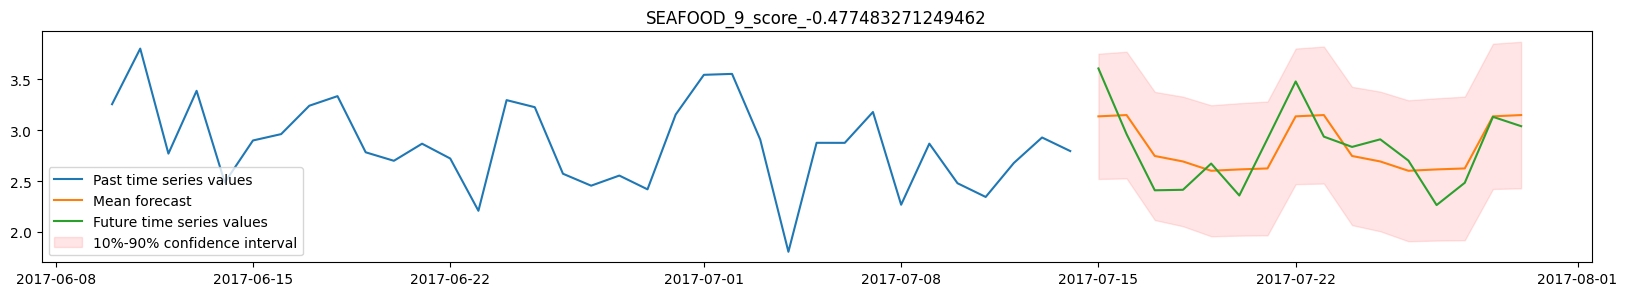

In [134]:
# plot result
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 3))

y_past = valid_data.loc[item_id][:-32]["sales"]
y_pred = result.loc[item_id]
y_test = valid_data.loc[item_id][-32:-16]["sales"]

plt.plot(y_past[-7*5:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"].values, y_pred["0.9"].values, color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend()
plt.title(item_id + "_score_" +str(eval_score))
plt.show()

In [54]:
result = predictor_saved.predict(train_data, known_covariates=test_data[known_covariates_cols])

Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: ETS/T19


## Auto모델

## hyperparameter에 지정

In [22]:
import autogluon.core as ag
from autogluon.timeseries.splitter import MultiWindowSplitter
splitter = MultiWindowSplitter(num_windows=1)
predictor = TimeSeriesPredictor(known_covariates_names=known_covariates_cols, target="sales", prediction_length=16, validation_splitter=splitter,
                                eval_metric="RMSE")
# predictor.fit(train_data=train_data,
#               hyperparameters={
#             "AutoETS": {"model":"ZZZ",
#             "n_jobs": -1,
#             "seasonal_period": ag.space.Categorical(1, 7, 14, 28, None)}
#             },hyperparameter_tune_kwargs={
#                 "scheduler": "local",
#                 "searcher": "auto",
#                 "num_trials": 30,
#             }, enable_ensemble=False)

predictor.fit(train_data=train_data,
              hyperparameters={
            "AutoETS": {}})

No path specified. Models will be saved in: "AutogluonModels/ag-20230606_104050/"
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': {'AutoETS': {}},
 'prediction_length': 16,
 'random_seed': None,
 'target': 'sales',
 'time_limit': None}
Provided training data set with 3008016 rows, 1782 items (item = single time series). Average time series length is 1688.0.
Training artifacts will be saved to: /home/mysunk/PJT/automl_study/msun/AutogluonModels/ag-20230606_104050
AutoGluon will save models to AutogluonModels/ag-20230606_104050/
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'sales

In [23]:
# select item_id to plot

item_id = "SEAFOOD_9"
idx = train_data.index.get_level_values(0) == item_id
valid_data = train_data[idx]

# pred validation
result = predictor.predict(valid_data[:-32], known_covariates=valid_data[known_covariates_cols][-32:-16])

eval_score = predictor.evaluate(valid_data[-32-16:-16], metric = "RMSE")

Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: AutoETS
Model not specified in predict, will default to the model with the best validation score: AutoETS


In [24]:
eval_score

-0.3758667155802027

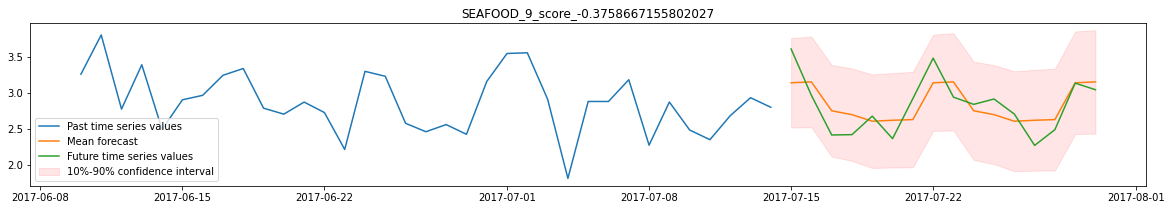

In [26]:
# plot validation
# plot result
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 3))

y_past = valid_data.loc[item_id][:-32]["sales"]
y_pred = result.loc[item_id]
y_test = valid_data.loc[item_id][-32:-16]["sales"]

plt.plot(y_past[-7*5:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"].values, y_pred["0.9"].values, color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend()
plt.title(item_id + "_score_" +str(eval_score))
plt.show()

In [29]:
result = predictor.predict(train_data, known_covariates=test_data[known_covariates_cols])
sample_submission = pd.read_csv("data/sample_submission.csv")
test_data["sales"] = np.expm1(result["mean"])
submission = pd.merge(sample_submission[["id"]], test_data.reset_index()[["id", "sales"]], on="id", how="left")

submission.to_csv("result/submit_3.csv", index=False) # 0.40607

Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: AutoETS


OSError: Cannot save file into a non-existent directory: 'result'

In [ ]:
submission.to_csv("result/submit_3.csv", index=False) # 0.40607

## directly

In [226]:
from autogluon.timeseries.models import AutoETSModel

predictor = AutoETSModel(**{
            "AutoETSModel": {"model":"ZZZ",
            "seasonal_period": ag.space.Int(1,20)}
            }, prediction_length=16)

No path specified. Models will be saved in: "AutogluonModels/ag-20230606_082423/AutoETS/"


In [227]:
train_autoets = train_data.rename(columns={"sales":"target"})

In [228]:
predictor.fit(train_data = train_autoets)

AutoETS

In [229]:
item_id = "SEAFOOD_9"
idx = train_autoets.index.get_level_values(0) == item_id
valid_data = train_autoets[idx]

# pred validation
result = predictor.predict(valid_data[:-32], known_covariates=valid_data[known_covariates_cols][-32:-16])

In [236]:
from sklearn.metrics import mean_squared_error

eval_score = mean_squared_error(valid_data[-32:-16]["target"],result["mean"], squared=False)

In [237]:
eval_score

0.2478769713203859

In [ ]:
# https://github.com/autogluon/autogluon/issues/565
# FIXME: score 다른 이유?

In [231]:
result

mean       0.1       0.2       0.3       0.4  \
item_id   timestamp                                                      
SEAFOOD_9 2017-07-15  3.136487  2.514022  2.727702  2.881779  3.013433   
          2017-07-16  3.149219  2.519836  2.735891  2.891681  3.024798   
          2017-07-17  2.747577  2.111351  2.329754  2.487238  2.621803   
          2017-07-18  2.693786  2.050789  2.271517  2.430677  2.566674   
          2017-07-19  2.602405  1.952708  2.175735  2.336554  2.473968   
          2017-07-20  2.615633  1.959304  2.184608  2.347068  2.485884   
          2017-07-21  2.625156  1.962263  2.189821  2.353905  2.494110   
          2017-07-22  3.136487  2.467093  2.696882  2.862576  3.004156   
          2017-07-23  3.149219  2.473387  2.705386  2.872674  3.015615   
          2017-07-24  2.747577  2.065367  2.299556  2.468422  2.612712   
          2017-07-25  2.693786  2.005258  2.241616  2.412046  2.557673   
          2017-07-26  2.602405  1.907615  2.146122  2.318103  2.465053   
          2017-07-27  2.615633  1.914638  2.155275  2.328791  2.477054   
          2017-07-28  2.625156  1.918011  2.160759  2.335798  2.485362   
          2017-07-29  3.136487  2.423244  2.668086  2.844634  2.995487   
          2017-07-30  3.149219  2.429931  2.676848  2.854892  3.007025   

                           0.5       0.6       0.7       0.8       0.9  
item_id   timestamp                                                     
SEAFOOD_9 2017-07-15  3.136487  3.259541  3.391194  3.545272  3.758951  
          2017-07-16  3.149219  3.273641  3.406758  3.562548  3.778602  
          2017-07-17  2.747577  2.873351  3.007915  3.165400  3.383803  
          2017-07-18  2.693786  2.820899  2.956895  3.116055  3.336783  
          2017-07-19  2.602405  2.730842  2.868255  3.029074  3.252101  
          2017-07-20  2.615633  2.745381  2.884197  3.046657  3.271961  
          2017-07-21  2.625156  2.756202  2.896407  3.060492  3.288049  
          2017-07-22  3.136487  3.268818  3.410398  3.576092  3.805881  
          2017-07-23  3.149219  3.282823  3.425765  3.593052  3.825052  
          2017-07-24  2.747577  2.882442  3.026732  3.195598  3.429787  
          2017-07-25  2.693786  2.829900  2.975527  3.145957  3.382315  
          2017-07-26  2.602405  2.739756  2.886707  3.058687  3.297194  
          2017-07-27  2.615633  2.754210  2.902474  3.075990  3.316627  
          2017-07-28  2.625156  2.764950  2.914514  3.089553  3.332301  
          2017-07-29  3.136487  3.277486  3.428340  3.604888  3.849730  
          2017-07-30  3.149219  3.291414  3.443546  3.621591  3.868508

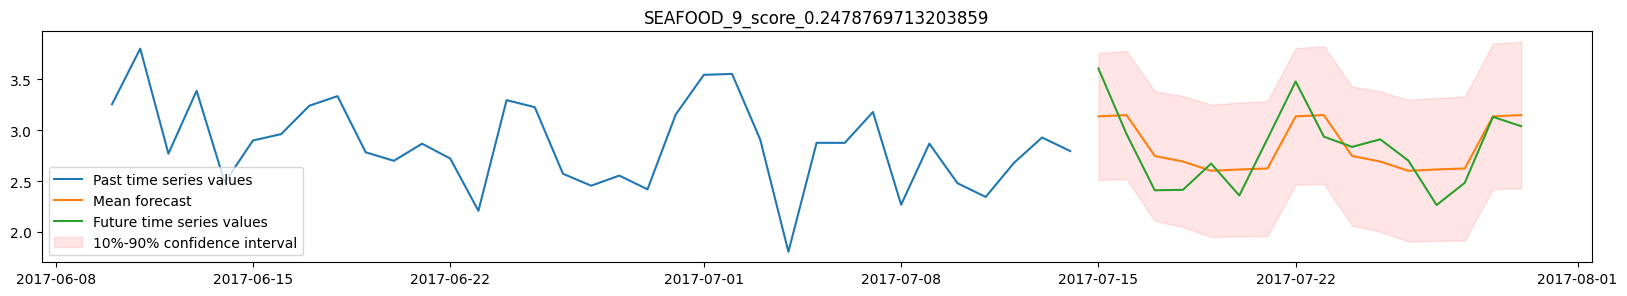

In [171]:
# plot validation
# plot result
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 3))

y_past = valid_data.loc[item_id][:-32]["target"]
y_pred = result.loc[item_id]
y_test = valid_data.loc[item_id][-32:-16]["target"]

plt.plot(y_past[-7*5:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"].values, y_pred["0.9"].values, color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend()
plt.title(item_id + "_score_" +str(eval_score))
plt.show()

In [56]:
sample_submission = pd.read_csv("data/sample_submission.csv")
test_data["sales"] = np.expm1(result["mean"])
submission = pd.merge(sample_submission[["id"]], test_data.reset_index()[["id", "sales"]], on="id", how="left")

submission.to_csv("result/submit_2.csv", index=False) # 0.40607